# Classificação de pontuação de crédito
Nomes: Carlos Bravo e Markson Arguello

DREs: 119136241 e 119132001

### Imports

In [80]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [81]:
random_state = 42

### Carregar dados

In [82]:
# Lê o arquivo csv
df = pd.read_csv('dados/CreditScoreData.csv')

# Mostra as 5 primeiras linhas
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age_Months,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x160f,CUS_0x21b1,February,Rick Rothackerj,28,004-07-5839,Teacher,"34,848","3,038",2,...,Good,605.03,38.55,320,No,18.82,40.39,High_spent_Large_value_payments,484.59,Good
1,0x1612,CUS_0x21b1,May,Rick Rothackerj,28,004-07-5839,Teacher,"34,848","3,038",2,...,Good,605.03,34.98,323,No,18.82,130.12,Low_spent_Small_value_payments,444.87,Good
2,0x1613,CUS_0x21b1,June,Rick Rothackerj,28,004-07-5839,Teacher,"34,848","3,038",2,...,Good,605.03,33.38,324,No,18.82,43.48,High_spent_Large_value_payments,481.51,Good
3,0x1615,CUS_0x21b1,August,Rick Rothackerj,28,004-07-5839,Teacher,"34,848","3,038",2,...,Good,605.03,32.93,326,No,18.82,218.90,Low_spent_Small_value_payments,356.08,Good
4,0x1626,CUS_0xb891,January,Jasond,54,072-31-6145,Entrepreneur,"30,690","2,612",2,...,Good,632.46,26.54,207,No,16.42,81.23,Low_spent_Large_value_payments,433.60,Standard


### Limpeza dos dados

In [83]:
# Remover ID e dados sensíveis
df = df.drop(['ID', 'Customer_ID', 'Name', 'SSN'], axis=1)

In [84]:
# Verifica valores nulos
lista = df.isnull().sum()

for i in range(len(lista)):
    if lista[i] > 0:
        print(lista.index[i], lista[i])

Type_of_Loan 2526


In [85]:
# Verifica linhas repetidas
df.duplicated().sum()

0

#### Converter colunas categóricas em numéricas

#### Coluna Month

In [86]:
# Mapeia cada mes para um numero
meses = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# Converte a coluna 'Month' para inteiro
df['Month'] = df['Month'].map(meses)


#### Coluna Credit_Mix

In [87]:
# Pega os valores distintos da coluna 'Credit_Mix'
df['Credit_Mix'].unique()

array(['Good', 'Standard', 'Bad'], dtype=object)

In [88]:
# Mapeia cada valor para um numero
credit_mix = {'Bad': 1, 'Standard': 2, 'Good': 3}

# Converte a coluna 'Credit_Mix' para inteiro
df['Credit_Mix'] = df['Credit_Mix'].map(credit_mix)


#### Coluna Payment_of_Min_Amount

In [89]:
# Pega os valores distintos da coluna 'Payment_of_Min_Amount'
df['Payment_of_Min_Amount'].unique()


array(['No', 'Yes'], dtype=object)

In [90]:
# Mapeia cada valor para um numero
payment_of_min_amount = {'Yes': 1, 'No': 0}

# Converte a coluna 'Payment_of_Min_Amount' para inteiro
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map(payment_of_min_amount)

#### Coluna Credit_Score

In [91]:
# Pega os valores distintos da coluna 'Credit_Score'
df['Credit_Score'].unique()

array(['Good', 'Standard', 'Poor'], dtype=object)

In [92]:
# Mapeia cada valor para um numero
credit_score = {'Poor': 1, 'Standard': 2, 'Good': 3}

# Converte a coluna 'Credit_Score' para inteiro
df['Credit_Score'] = df['Credit_Score'].map(credit_score)

#### One-Hot Encoding

In [93]:
# Função para criar One-Hot Encoding para uma coluna
def one_hot_encoding(col):
    global df
    y = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, y], axis=1)
    df = df.drop([col], axis=1)

In [94]:
# Aplica a função para as colunas 'Occupation' e 'Payment_Behaviour'
one_hot_encoding('Occupation')
one_hot_encoding('Payment_Behaviour')

In [95]:
df.head()

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,...,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
0,2,28,"34,848","3,038",2,4,6,1,Credit-Builder Loan,7,...,0,0,1,0,1,0,0,0,0,0
1,5,28,"34,848","3,038",2,4,6,1,Credit-Builder Loan,3,...,0,0,1,0,0,0,0,0,0,1
2,6,28,"34,848","3,038",2,4,6,1,Credit-Builder Loan,3,...,0,0,1,0,1,0,0,0,0,0
3,8,28,"34,848","3,038",2,4,6,1,Credit-Builder Loan,3,...,0,0,1,0,0,0,0,0,0,1
4,1,54,"30,690","2,612",2,5,4,1,Not Specified,0,...,0,0,0,0,0,0,0,1,0,0


In [96]:
# Substitui nan, null por string vazia na coluna 'Type_of_Loan'
df['Type_of_Loan'] = df['Type_of_Loan'].fillna('')
df['Type_of_Loan'] = df['Type_of_Loan'].replace('null', '')

# Pega os valores da coluna 'Type_of_Loan'
lista = df['Type_of_Loan']

valores = []

for elemento in lista:
    parte = elemento.replace('and ', '').split(', ')
    valores.append(parte)

In [97]:
# Cria um dataframe com o encode da coluna 'Type_of_Loan'
valores = pd.Series(valores, dtype='object')
encoding = pd.get_dummies(valores.apply(pd.Series, dtype='object').stack()).groupby(level=0).sum()

In [98]:
# Remove coluna 'Not Specified' e '' 
encoding = encoding.drop(['Not Specified', ''], axis=1)

In [99]:
# Concatena o encoding com o dataframe
df = pd.concat([df, encoding], axis=1)

# Substitui nan por 0
df = df.fillna(0)

# Remove a coluna 'Type_of_Loan'
df = df.drop(['Type_of_Loan'], axis=1)

In [100]:
df.head()

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Payday Loan,Personal Loan,Student Loan
0,2,28,"34,848","3,038",2,4,6,1,7,1,...,0,0,0,1,0,0,0,0,0,0
1,5,28,"34,848","3,038",2,4,6,1,3,1,...,0,1,0,1,0,0,0,0,0,0
2,6,28,"34,848","3,038",2,4,6,1,3,0,...,0,0,0,1,0,0,0,0,0,0
3,8,28,"34,848","3,038",2,4,6,1,3,4,...,0,1,0,1,0,0,0,0,0,0
4,1,54,"30,690","2,612",2,5,4,1,0,6,...,0,0,0,0,0,0,0,0,0,0


#### Converte colunas com números de formato string para float

In [101]:
# Função para converter a coluna para float
def converte_para_float(col):
    global df
    df[col].replace('[, ]', '', regex=True, inplace=True)
    df[col] = df[col].astype(float)

In [102]:
for col in df.columns:
    if df[col].dtype == 'object':
        converte_para_float(col)

In [103]:
df.head()

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Payday Loan,Personal Loan,Student Loan
0,2,28,34848.0,3038.0,2,4,6,1,7,1,...,0,0,0,1,0,0,0,0,0,0
1,5,28,34848.0,3038.0,2,4,6,1,3,1,...,0,1,0,1,0,0,0,0,0,0
2,6,28,34848.0,3038.0,2,4,6,1,3,0,...,0,0,0,1,0,0,0,0,0,0
3,8,28,34848.0,3038.0,2,4,6,1,3,4,...,0,1,0,1,0,0,0,0,0,0
4,1,54,30690.0,2612.0,2,5,4,1,0,6,...,0,0,0,0,0,0,0,0,0,0


### Padronização dos dados

In [104]:
colunas_para_conversao = [
    "Age",
    "Annual_Income",
    "Monthly_Inhand_Salary",
    "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Interest_Rate",
    "Num_of_Loan",
    "Delay_from_due_date",
    "Num_of_Delayed_Payment",
    "Changed_Credit_Limit",
    "Num_Credit_Inquiries",
    "Credit_Mix",
    "Outstanding_Debt",
    "Credit_Utilization_Ratio",
    "Credit_History_Age_Months",
    "Payment_of_Min_Amount",
    "Total_EMI_per_month",
    "Amount_invested_monthly",
    "Monthly_Balance"
]

In [105]:
# Padroniza as colunas selecionadas
scaler = StandardScaler()
df_padronizado = df.copy()
df_padronizado[colunas_para_conversao] = scaler.fit_transform(df[colunas_para_conversao])

df_padronizado.head(10)

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Payday Loan,Personal Loan,Student Loan
0,2,-0.472322,-0.097249,-0.329689,-1.544442,-0.785454,-1.030988,-1.070128,-0.999420,-0.133966,...,0,0,0,1,0,0,0,0,0,0
1,5,-0.472322,-0.097249,-0.329689,-1.544442,-0.785454,-1.030988,-1.070128,-1.268561,-0.133966,...,0,1,0,1,0,0,0,0,0,0
2,6,-0.472322,-0.097249,-0.329689,-1.544442,-0.785454,-1.030988,-1.070128,-1.268561,-0.138210,...,0,0,0,1,0,0,0,0,0,0
3,8,-0.472322,-0.097249,-0.329689,-1.544442,-0.785454,-1.030988,-1.070128,-1.268561,-0.121233,...,0,1,0,1,0,0,0,0,0,0
4,1,1.945399,-0.100108,-0.467344,-1.544442,-0.297915,-1.259128,-1.070128,-1.470417,-0.112745,...,0,0,0,0,0,0,0,0,0,0
5,2,1.945399,-0.100108,-0.467344,-1.544442,-0.297915,-1.259128,-1.070128,-1.133991,-0.125477,...,0,1,0,0,0,0,0,0,0,0
6,3,2.038389,-0.100108,-0.467344,-1.544442,-0.297915,-1.259128,-1.070128,-1.268561,-0.100012,...,0,0,0,0,0,0,0,0,0,0
7,7,-1.123247,-0.096768,-0.389469,0.572659,-0.297915,-1.145058,-1.478268,-0.797565,-0.074547,...,0,1,0,0,0,0,0,0,0,0
8,4,-0.193354,-0.070385,0.623881,-0.697602,-0.297915,-0.802848,-1.478268,-0.932135,-0.108500,...,0,1,0,0,0,0,0,0,0,0
9,5,-0.937269,-0.042262,1.869564,-1.544442,-0.297915,-0.916918,-0.253849,-0.730279,-0.091524,...,0,0,1,0,1,0,0,0,1,0


### Verificação de Boxplot e Variância

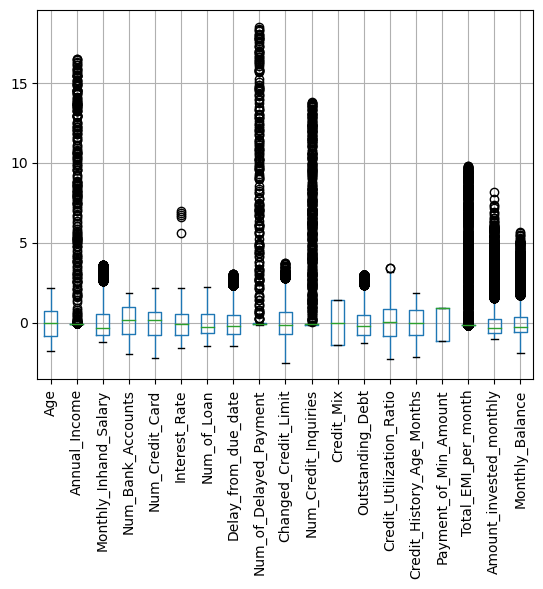

In [106]:
# Boxplot de df_padronizado para as colunas selecionadas em colunas_para_conversao
df_padronizado[colunas_para_conversao].boxplot(rot=90)
plt.show()

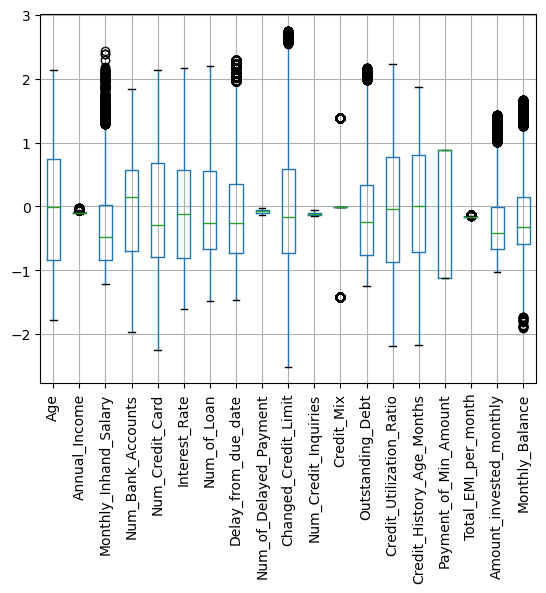

In [107]:
# Remove outliers de df_padronizado usando o IQR
for col in colunas_para_conversao:
    q1 = df_padronizado[col].quantile(0.25)
    q3 = df_padronizado[col].quantile(0.75)
    iqr = q3 - q1
    df_padronizado = df_padronizado[(df_padronizado[col] >= q1 - 1.5 * iqr) & (df_padronizado[col] <= q3 + 1.5 * iqr)]

# Boxplot de df_padronizado para as colunas selecionadas em colunas_para_conversao
df_padronizado[colunas_para_conversao].boxplot(rot=90)
plt.show()

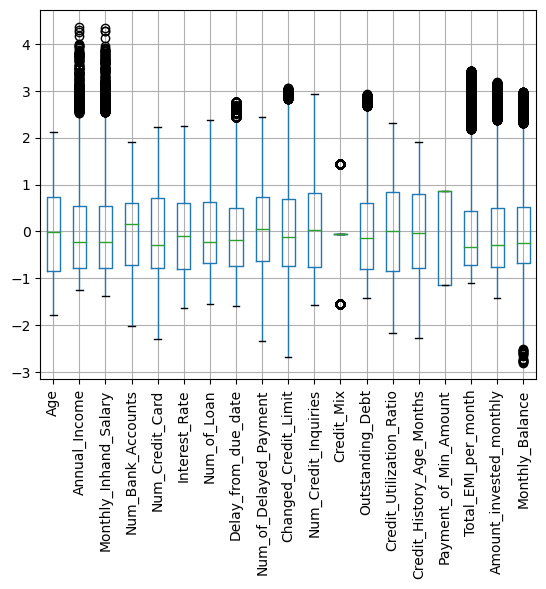

In [108]:
df_outliers = df.copy()

# Remove outliers de df_outliers usando o IQR
for col in colunas_para_conversao:
    q1 = df_outliers[col].quantile(0.25)
    q3 = df_outliers[col].quantile(0.75)
    iqr = q3 - q1
    df_outliers = df_outliers[(df_outliers[col] >= q1 - 1.5 * iqr) & (df_outliers[col] <= q3 + 1.5 * iqr)]

# Padroniza as colunas selecionadas
scaler = StandardScaler()
df_padronizado_outliers = df_outliers.copy()
df_padronizado_outliers[colunas_para_conversao] = scaler.fit_transform(df_outliers[colunas_para_conversao])

# Boxplot de df_padronizado para as colunas selecionadas em colunas_para_conversao
df_padronizado_outliers[colunas_para_conversao].boxplot(rot=90)
plt.show()

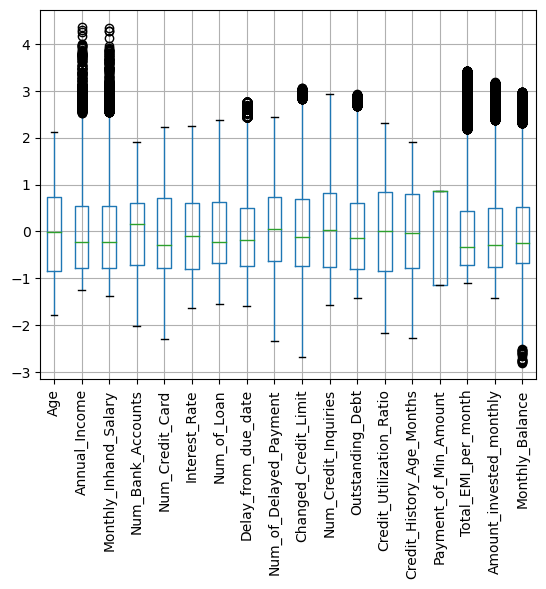

In [111]:
novo_colunas_para_conversao = [c for c in colunas_para_conversao if c != 'Credit_Mix']

df_outliers = df.copy()

# Remove outliers de df_outliers usando o IQR
for col in novo_colunas_para_conversao:
    q1 = df_outliers[col].quantile(0.25)
    q3 = df_outliers[col].quantile(0.75)
    iqr = q3 - q1
    df_outliers = df_outliers[(df_outliers[col] >= q1 - 1.5 * iqr) & (df_outliers[col] <= q3 + 1.5 * iqr)]

# Padroniza as colunas selecionadas
scaler = StandardScaler()
df_padronizado_outliers_semcreditmix = df_outliers.copy()
df_padronizado_outliers_semcreditmix.drop('Credit_Mix', axis=1, inplace=True)
df_padronizado_outliers_semcreditmix[novo_colunas_para_conversao] = scaler.fit_transform(df_outliers[novo_colunas_para_conversao])

# Boxplot de df_padronizado para as colunas selecionadas em novo_colunas_para_conversao
df_padronizado_outliers_semcreditmix[novo_colunas_para_conversao].boxplot(rot=90)
plt.show()

In [112]:
df_final = df_padronizado_outliers_semcreditmix.copy()

### Criação de modelos

In [113]:
# Cria o modelo usando arvore de decisao
def cria_modelo_arvore_decisao(max_depth=None, min_samples_leaf=1, min_samples_split=2):
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, random_state=random_state)
    return modelo

# Treina o modelo
def treina_modelo(modelo, X_train, y_train):
    modelo.fit(X_train, y_train)
    return modelo

# Faz a predição
def faz_predicao(modelo, X_test):
    y_pred = modelo.predict(X_test)
    return y_pred

# Calcula o relatório de classificação
def calcula_relatorio_classificacao(y_test, y_pred):
    print(classification_report(y_test, y_pred, target_names=['Poor', 'Standard', 'Good']))

# Pipeline de modelo
def pipeline_modelo(cria_modelo, X_train, y_train, X_test, y_test, **kwargs):
    modelo = cria_modelo(**kwargs)
    modelo = treina_modelo(modelo, X_train, y_train)
    y_pred = faz_predicao(modelo, X_test)
    calcula_relatorio_classificacao(y_test, y_pred)
    return modelo

#### Execução  

In [114]:
# Separa os dados em treino e teste
X = df_final.drop(['Credit_Score'], axis=1)
y = df_final['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

In [115]:
model = pipeline_modelo(cria_modelo_arvore_decisao, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

        Poor       0.65      0.65      0.65      1630
    Standard       0.71      0.72      0.71      2910
        Good       0.52      0.51      0.51       822

    accuracy                           0.66      5362
   macro avg       0.63      0.62      0.63      5362
weighted avg       0.66      0.66      0.66      5362

